### Manual Classifier
The idea is to start with an "absolute" mapping of the chords - write some sort of script to see how close we can get to identification without machine learning

In [9]:
# imports
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.io.wavfile import read as read_wav
from scipy import fft,signal
from sklearn.preprocessing import minmax_scale
import warnings
from tqdm import tqdm

In [10]:
A_FREQ = 440 
NOTES = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#'] 

In [11]:

def plot_freq_file(fileName,FREQ_FROM = A_FREQ*2**-2,FREQ_TO = A_FREQ*2**4):
    rate, data_raw = read_wav(fileName)
    data = (data_raw[:,0]+data_raw[:,1]).astype(np.float32) 
    data = minmax_scale(data,(-1.,1.))
 
    freq_image = fft.rfft(data,norm='forward') 
    freq_scale = fft.rfftfreq(len(data),1./rate)
    
    f_idx = np.where((freq_scale>FREQ_FROM)&(freq_scale<FREQ_TO)) 
    
    fig, ax = plt.subplots(1, 1)
    ax.set_xscale('log',base=2.) # log scale base 2 of freq-> tone change in one octave is freq multiplication by 2 
    plt.plot(freq_scale[f_idx],np.abs(freq_image[f_idx]))
    plt.title('Fourier Transform of the Audio Signal')
    plt.xlabel('Frequency, [Hz]')
    plt.xticks((110,220,440,880,1760,3520),('110','220','440','880','1760','3520'))
    plt.ylabel('Magnitude')

In [12]:
# try it out on a few of the files in /data/train_set.csv:
train_set = pd.read_csv('data/train_set.csv')
test_set = pd.read_csv('data/test_set.csv')
print(train_set.head())

# remove the chords that are not maj or min in the Quality column
train_set = train_set[train_set['Quality'].isin(['maj', 'min', 'dim', 'aug'])]
test_set = test_set[test_set['Quality'].isin(['maj', 'min', 'dim', 'aug'])]

                                    File Path Root Note  Octave Quality  \
0        data/chords/dim/Eb-7-dim-chord-1.wav        Eb       7     dim   
1   data/chords/min7b5/C-3-min7b5-chord-1.wav         C       3  min7b5   
2       data/chords/dim7/E-6-dim7-chord-0.wav         E       6    dim7   
3        data/chords/min/Bb-5-min-chord-0.wav        Bb       5     min   
4  data/chords/maj7_2/Ab-5-maj7_2-chord-0.wav        Ab       5  maj7_2   

   Inversion  
0          1  
1          1  
2          0  
3          0  
4          0  


Eb
dim
Ab
maj
Bb
min


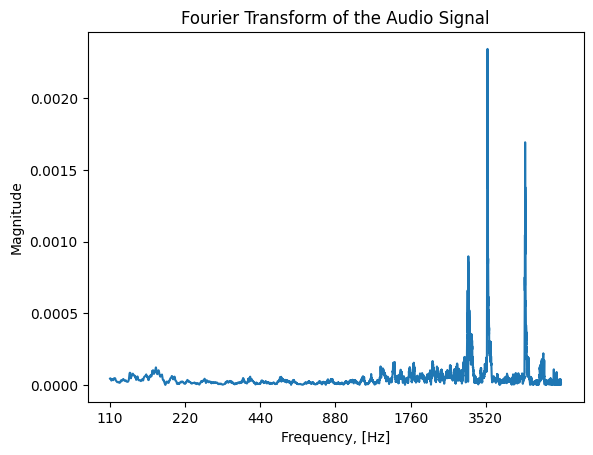

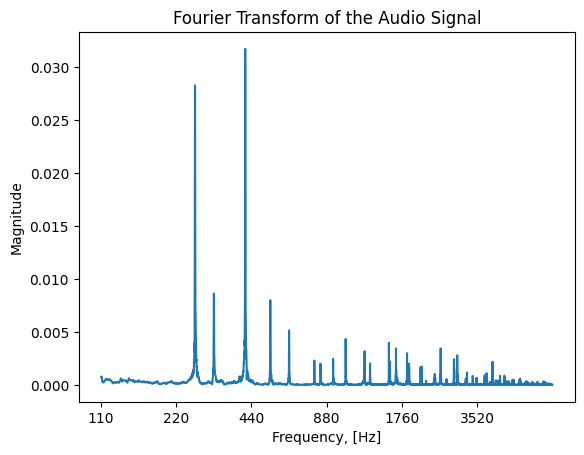

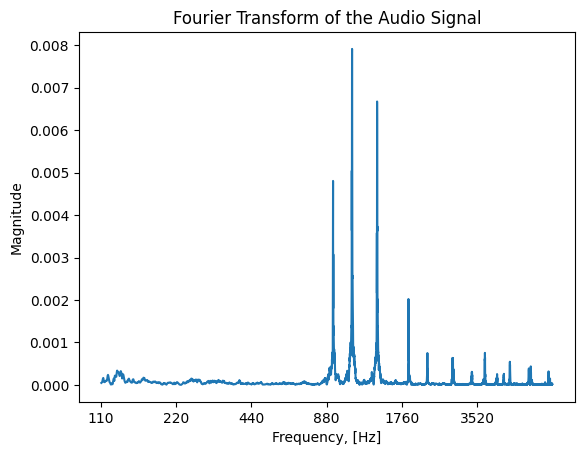

In [13]:
# run plot_freq_file on a few of the files in /data/train_set.csv:
print(train_set['Root Note'].iloc[0])
print(train_set['Quality'].iloc[0])
plot_freq_file(train_set['File Path'].iloc[0])
print(train_set['Root Note'].iloc[2])
print(train_set['Quality'].iloc[2])
plot_freq_file(train_set['File Path'].iloc[2])
print(train_set['Root Note'].iloc[1])
print(train_set['Quality'].iloc[1])
plot_freq_file(train_set['File Path'].iloc[1])


In [16]:
def note_from_freq(freq):
    r = 12.0*np.log2(freq/A_FREQ)
    return r

def freq_from_note(r):
    f = A_FREQ*2**(r/12)
    return f

# gets the maximum volume of the note in the fft image for a given note within a window of frequency
def get_note_volume(note,fft_image,fft_freq,note_window=0.2):
    if isinstance(note,str):
        note = NOTES.index(note)
    try:
        f0 = freq_from_note(note-note_window)
        f1 = freq_from_note(note+note_window)
        f_idx = np.where((fft_freq>=f0)&(fft_freq<=f1)) 
        maxVol = np.max((fft_image[f_idx]))
    except:
        return 0
    
    return maxVol

# gets the maximum volume of the note in the fft image for a given note over all octaves
def get_notes_volume(notes,fft_image,fft_freq,oct_from=-4.,oct_to=8.):
    # if note is a string, convert to index
    if isinstance(notes,str):
        notes = NOTES.index(notes)
    
    # get the notes in the range of octaves
    notes = np.arange(notes+12.*oct_from,notes+12.*oct_to,12.0)
    vol = []

    # get the volume of each note
    for rn in notes:
        vol.append(get_note_volume(rn,fft_image,fft_freq))
        
    # return the maximum volume of that note
    return np.max(vol)


# plot the notes for a given file
def plot_notes(fileName):
    # read the file
    rate,data_raw = read_wav(fileName)
    # convert to mono
    data = (data_raw[:,0]+data_raw[:,1]).astype(np.float32)
    # scale the data
    data = minmax_scale(data,(-1.,1.)) 
    # get the fft and freq array
    fft_image = np.abs(fft.rfft(data,norm='forward')) 
    fft_freq = fft.rfftfreq(len(data),1./rate)

    # get the volume of each note
    vol_matrix = np.ndarray(shape=(12),dtype=np.float32)
    for note in range(12):
        vol_matrix[note] = get_notes_volume(note,fft_image,fft_freq)

    # plot the bins
    plt.bar(NOTES, vol_matrix)
    plt.show()

Eb
dim


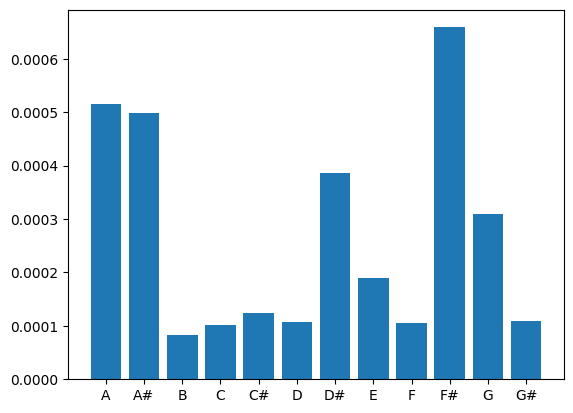

None
Ab
maj


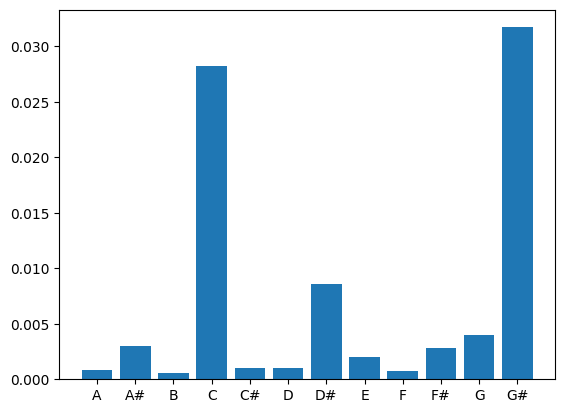

None
Bb
min


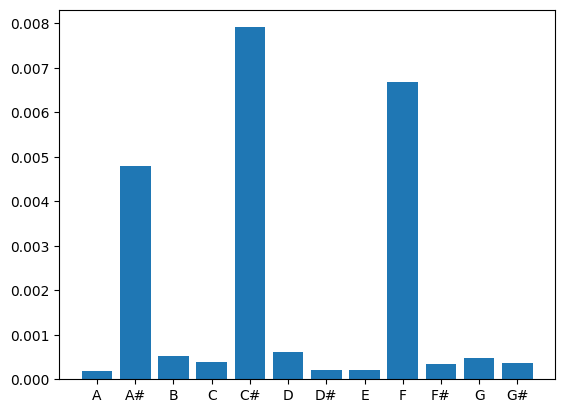

None


In [17]:
print(train_set['Root Note'].iloc[0])
print(train_set['Quality'].iloc[0])
print(plot_notes(train_set['File Path'].iloc[0]))
print(train_set['Root Note'].iloc[2])
print(train_set['Quality'].iloc[2])
print(plot_notes(train_set['File Path'].iloc[2]))
print(train_set['Root Note'].iloc[1])
print(train_set['Quality'].iloc[1])
print(plot_notes(train_set['File Path'].iloc[1]))


In [18]:
def chord_quality(fileName):
    rate, data_raw = read_wav(fileName)
    data = (data_raw[:,0]+data_raw[:,1]).astype(np.float32) # stereo of any type -> mono of float32
    data = minmax_scale(data,(-1.,1.))
    fft_image = np.abs(fft.rfft(data,norm='forward'))
    fft_freq = fft.rfftfreq(len(data),1./rate)

    major_vol = []
    minor_vol = []
    diminished_vol = []
    augmented_vol = []

    for rnote in range(12):
        vol = get_notes_volume(rnote,fft_image,fft_freq)
        v3 = get_notes_volume((rnote+3)%12,fft_image,fft_freq)
        v4 = get_notes_volume((rnote+4)%12,fft_image,fft_freq)
        v6 = get_notes_volume((rnote+6)%12,fft_image,fft_freq)
        v7 = get_notes_volume((rnote+7)%12,fft_image,fft_freq)
        v8 = get_notes_volume((rnote+8)%12,fft_image,fft_freq)

        major_vol.append(vol + v4 + v7)
        minor_vol.append(vol + v3 + v7)
        diminished_vol.append(vol + v3 + v6)
        augmented_vol.append(vol + v4 + v8)
    
    major_max = [max(major_vol), NOTES[major_vol.index(max(major_vol))]]
    minor_max = [max(minor_vol), NOTES[minor_vol.index(max(minor_vol))]] 
    diminished_max = [max(diminished_vol), NOTES[diminished_vol.index(max(diminished_vol))]] 
    augmented_max = [max(augmented_vol), NOTES[augmented_vol.index(max(augmented_vol))]] 

    if max(major_max[0], minor_max[0], diminished_max[0], augmented_max[0]) == major_max[0]:
        return 'maj', major_max[1]
    elif max(major_max[0], minor_max[0], diminished_max[0], augmented_max[0]) == minor_max[0]:
        return 'min', minor_max[1]
    elif max(major_max[0], minor_max[0], diminished_max[0], augmented_max[0]) == diminished_max[0]:
        return 'dim', diminished_max[1]
    else:
        return 'aug', augmented_max[1]

In [19]:
# print a summary of the chord qualities in the train set
print(train_set['Quality'].value_counts())

Quality
aug    179
dim    178
min    178
maj    178
Name: count, dtype: int64


In [20]:
train_set['File Path'] = train_set['File Path'].str.replace('#', 's')
test_set['File Path'] = test_set['File Path'].str.replace('#', 's')

In [21]:
# test this function on the entire training set (by checking if chord_quality matches the Quality column)
# and report the accuracy of the function
major_correct = 0
major_incorrect = 0
minor_correct = 0
minor_incorrect = 0
diminished_correct = 0
diminished_incorrect = 0
augmented_correct = 0
augmented_incorrect = 0

root_note_correct = 0
root_note_incorrect = 0

for i in tqdm(range(len(train_set))):
    quality, root_note = chord_quality(train_set['File Path'].iloc[i])
    if train_set['Quality'].iloc[i] == 'maj':
        if quality == 'maj':
            major_correct += 1
        else:
            major_incorrect += 1


    elif train_set['Quality'].iloc[i] == 'min':
        if quality == 'min':
            minor_correct += 1
        else:
            minor_incorrect += 1

    elif train_set['Quality'].iloc[i] == 'dim':
        if quality == 'dim':
            diminished_correct += 1
        else:
            diminished_incorrect += 1

    elif train_set['Quality'].iloc[i] == 'aug':
        if quality == 'aug':
            augmented_correct += 1
        else:
            augmented_incorrect += 1
    
    if root_note != train_set['Root Note'].iloc[i] and train_set['Quality'].iloc[i] != 'aug':
        root_note_incorrect += 1
    else:
        root_note_correct += 1

print('major correct: ', major_correct)
print('major incorrect: ', major_incorrect)
print('minor correct: ', minor_correct)
print('minor incorrect: ', minor_incorrect)
print('diminished correct: ', diminished_correct)
print('diminished incorrect: ', diminished_incorrect)
print('augmented correct: ', augmented_correct)
print('augmented incorrect: ', augmented_incorrect)
print('root note correct: ', root_note_correct)
print('root note incorrect: ', root_note_incorrect)

print('major accuracy: ', major_correct/(major_correct+major_incorrect))
print('minor accuracy: ', minor_correct/(minor_correct+minor_incorrect))
print('diminished accuracy: ', diminished_correct/(diminished_correct+diminished_incorrect))
print('augmented accuracy: ', augmented_correct/(augmented_correct+augmented_incorrect))
print('root note accuracy: ', root_note_correct/(root_note_correct+root_note_incorrect))

print('overall chord quality accuracy: ', (major_correct+minor_correct+diminished_correct+augmented_correct)/(major_correct+major_incorrect+minor_correct+minor_incorrect+diminished_correct+diminished_incorrect+augmented_correct+augmented_incorrect))


  0%|          | 0/713 [00:00<?, ?it/s]

100%|██████████| 713/713 [00:10<00:00, 70.37it/s]

major correct:  174
major incorrect:  4
minor correct:  172
minor incorrect:  6
diminished correct:  173
diminished incorrect:  5
augmented correct:  173
augmented incorrect:  6
root note correct:  573
root note incorrect:  140
major accuracy:  0.9775280898876404
minor accuracy:  0.9662921348314607
diminished accuracy:  0.9719101123595506
augmented accuracy:  0.9664804469273743
root note accuracy:  0.8036465638148668
overall chord quality accuracy:  0.97054698457223


100%|██████████| 307/307 [00:04<00:00, 68.30it/s]


major correct:  76
major incorrect:  1
minor correct:  74
minor incorrect:  3
diminished correct:  74
diminished incorrect:  3
augmented correct:  72
augmented incorrect:  4
root note correct:  241
root note incorrect:  66
major accuracy:  0.987012987012987
minor accuracy:  0.961038961038961
diminished accuracy:  0.961038961038961
augmented accuracy:  0.9473684210526315
root note accuracy:  0.7850162866449512
overall chord quality accuracy:  0.9641693811074918


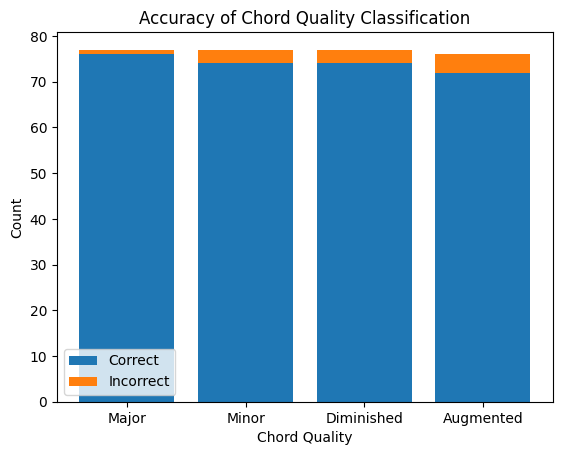

In [22]:
# test this function on the entire test set (by checking if chord_quality matches the Quality column)
# and report the accuracy of the function

major_correct = 0
major_incorrect = 0
minor_correct = 0
minor_incorrect = 0
diminished_correct = 0
diminished_incorrect = 0
augmented_correct = 0
augmented_incorrect = 0

root_note_correct = 0
root_note_incorrect = 0

for i in tqdm(range(len(test_set))):
    quality, root_note = chord_quality(test_set['File Path'].iloc[i])
    if test_set['Quality'].iloc[i] == 'maj':
        if quality == 'maj':
            major_correct += 1
        else:
            major_incorrect += 1

    elif test_set['Quality'].iloc[i] == 'min':
        if quality == 'min':
            minor_correct += 1
        else:
            minor_incorrect += 1

    elif test_set['Quality'].iloc[i] == 'dim':
        if quality == 'dim':
            diminished_correct += 1
        else:
            diminished_incorrect += 1

    elif test_set['Quality'].iloc[i] == 'aug':
        if quality == 'aug':
            augmented_correct += 1
        else:
            augmented_incorrect += 1
    
    if root_note != test_set['Root Note'].iloc[i] and test_set['Quality'].iloc[i] != 'aug':
        root_note_incorrect += 1
    else:
        root_note_correct += 1

print('major correct: ', major_correct)
print('major incorrect: ', major_incorrect)
print('minor correct: ', minor_correct)
print('minor incorrect: ', minor_incorrect)
print('diminished correct: ', diminished_correct)
print('diminished incorrect: ', diminished_incorrect)
print('augmented correct: ', augmented_correct)
print('augmented incorrect: ', augmented_incorrect)
print('root note correct: ', root_note_correct)
print('root note incorrect: ', root_note_incorrect)

print('major accuracy: ', major_correct/(major_correct+major_incorrect))
print('minor accuracy: ', minor_correct/(minor_correct+minor_incorrect))
print('diminished accuracy: ', diminished_correct/(diminished_correct+diminished_incorrect))
print('augmented accuracy: ', augmented_correct/(augmented_correct+augmented_incorrect))
print('root note accuracy: ', root_note_correct/(root_note_correct+root_note_incorrect))

print('overall chord quality accuracy: ', (major_correct+minor_correct+diminished_correct+augmented_correct)/(major_correct+major_incorrect+minor_correct+minor_incorrect+diminished_correct+diminished_incorrect+augmented_correct+augmented_incorrect))

# create a graph or chart from the results
import matplotlib.pyplot as plt

labels = ['Major', 'Minor', 'Diminished', 'Augmented']
correct = [major_correct, minor_correct, diminished_correct, augmented_correct]
incorrect = [major_incorrect, minor_incorrect, diminished_incorrect, augmented_incorrect]

x = range(len(labels))

plt.bar(x, correct, label='Correct')
plt.bar(x, incorrect, bottom=correct, label='Incorrect')

plt.xlabel('Chord Quality')
plt.ylabel('Count')
plt.title('Accuracy of Chord Quality Classification')
plt.xticks(x, labels)
plt.legend()

plt.show()


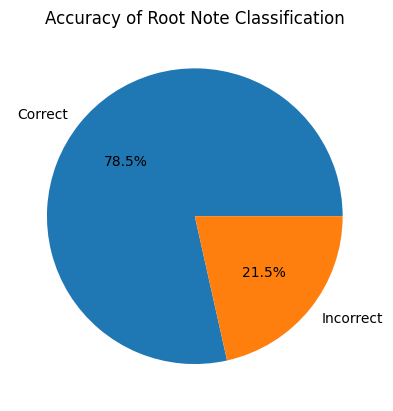

In [23]:
# plot a pie chart of incorrect vs correct eoot notes

labels = ['Correct', 'Incorrect']
plt.pie([root_note_correct, root_note_incorrect], labels=labels, autopct='%1.1f%%')
plt.title('Accuracy of Root Note Classification')
plt.show()

In [1]:
# credit to: https://www.kaggle.com/code/slawagrechaniy/laba5 and https://www.kaggle.com/code/ahmetcelik158/mathematics-of-music-chord-classification for assisting with some of the functions in this notebook